# How to USE
- [Import Modules](#imports)
- [Define functions](#Functions)
- - [Helper Functions](#Helper_functions)
- - [NR Function](#NR_function)
- - [Loss Function](#Loss)
- - [Fitness Function](#Fitness)
- - [COOT Function](#COOT)
- [Load data](#Load_data)


[link text](#try)

# <a name="imports">Import Modules</a>



In [ ]:
import numpy as np
import pandas as pd
import io

# Define functions
<a name = "Functions"></a>

### Helper functions
<a name="Helper_functions"></a>

In [ ]:


def setup_power_system(bus_data_with_pu, line_data):
    """
    Set up the power system for load flow analysis.

    Parameters:
    bus_data_with_pu (numpy array): Bus data with per unit values.
    line_data (numpy array): Line data with resistance, reactance, and susceptance.

    Returns:
    V (numpy array): Initial voltage vector.
    Y_bus (numpy array): Admittance matrix.
    bus_data (numpy array): Bus data array.
    Pg_pu (numpy array): Active power generation in per unit.
    Qg_pu (numpy array): Reactive power generation in per unit.
    Pd_pu (numpy array): Active power demand in per unit.
    Qd_pu (numpy array): Reactive power demand in per unit.
    """
    n = bus_data_with_pu.shape[0]

    # Initialize voltage vector
    V = bus_data_with_pu[:, 2] * np.exp(1j * np.radians(bus_data_with_pu[:, 3]))

    # Initialize Y-Bus matrix
    Y_bus = np.zeros((n, n), dtype=complex)
    r_bus = np.zeros((n, n), dtype=complex)

    # Fill Y-Bus matrix from line data including line charging (susceptance B)
    for line in line_data:
        from_bus = int(line[0]) - 1
        to_bus = int(line[1]) - 1
        r = line[2]
        x = line[3]
        b = line[4]

        z = r + 1j * x
        y = 1.0 / z
        yc = 1j * b #/ 2  # Incorporate line charging into admittance

        #diagonal elements
        Y_bus[from_bus, from_bus] += (y + yc)
        Y_bus[to_bus, to_bus] += (y + yc)
        #off diagonal elements
        Y_bus[from_bus, to_bus] -= y
        Y_bus[to_bus, from_bus] -= y
        # rbus
        r_bus[from_bus, to_bus] += r
        r_bus[to_bus, from_bus] += r

    # Extract other relevant data from bus_data_with_pu
    Pd_pu = bus_data_with_pu[:, 4]
    Qd_pu = bus_data_with_pu[:, 5]
    Pg_pu = bus_data_with_pu[:, 6]
    Qg_pu = bus_data_with_pu[:, 7]
    Q_max = bus_data_with_pu[:, 8]
    Q_min = bus_data_with_pu[:, 9]
    bus_data = bus_data_with_pu[:, :2]  # Only bus number and type
    return V, Y_bus, r_bus, bus_data, Pd_pu, Qd_pu, Pg_pu, Qg_pu, Q_max, Q_min

In [ ]:
# Function to calculate complex power injection
def calc_complex_power_injection(i,V, Y_bus ):
    I = np.dot(Y_bus[i], V)
    S_inj = V[i] * np.conj(I)

    return S_inj

In [ ]:
# Function to calculate complex power injection
def calc_complex_power_injection(i,V, Y_bus ):
    P = np.sum([
        np.abs(V[i]) * np.abs(V[k]) * np.abs(Y_bus[i, k]) * np.cos(np.angle(Y_bus[i, k]) + np.angle(V[k]) - np.angle(V[i]))
        for k in range(len(V))
    ])
    Q =- np.sum([
        np.abs(V[i]) * np.abs(V[k]) * np.abs(Y_bus[i, k]) * np.sin(np.angle(Y_bus[i, k]) + np.angle(V[k]) - np.angle(V[i]))
        for k in range(len(V))
    ])
    return P + 1j*Q

In [ ]:
def calc_mismatch(i,S_inj ,bus_data,Pgi,Qgi,Pdi, Qdi,Qi_max, Qi_min):
    delta_p = 0
    delta_q = 0
    # print(Pgi,Qgi,Pdi, Qdi,Qi_max, Qi_min)
    if bus_data[i,1] == 1:  # Slack bus
        pass

    elif bus_data[i,1] == 2: # PV bus
        delta_p = Pgi - Pdi - np.real(S_inj)
        Q_calc = np.imag(S_inj)
        if Q_calc > Qi_max:
            Q_spec = Qi_max
            # bus_data[i,1] = 0
        elif Q_calc < Qi_min:
            Q_spec = Qi_min
            # bus_data[i,1] = 0 # uncomment later
        else:
            Q_spec = Qgi - Qdi

        delta_q = Q_spec - Q_calc

    elif bus_data[i,1] == 0:  # pQ bus
        delta_p = Pgi - Pdi - np.real(S_inj)
        delta_q = Qgi - Qdi -  np.imag(S_inj)
    # print('delta_p and delta q :  ',delta_p,delta_q)
    return delta_p, delta_q





In [ ]:

def exclude_rows_cols(matrix, indices):
    return np.delete(np.delete(matrix, indices, axis=0), indices, axis=1)



In [ ]:
def reinsert_zeros(reduced_vector, indices, length):
    full_vector = np.zeros(length)
    reduced_index = 0
    for i in range(length):
        if i not in indices:
            full_vector[i] = reduced_vector[reduced_index]
            reduced_index += 1
    return full_vector

## Newton Raphson
<a name = "NR_function"></a>

In [ ]:
# Function to perform Newton-Raphson load flow analysis
def newton_raphson_load_flow(Y_bus, Vol, bus_data_,Pd_pu,Qd_pu,Pg_pu, Qg_pu, Q_max, Q_min ):
    V = Vol.copy()
    bus_data = bus_data_.copy()
    n = V.shape[0]
    max_iter = 50
    tol = 1e-9


    # Initialize mismatches
    P_mismatch = np.zeros(n)
    Q_mismatch = np.zeros(n)

    # Initialize iteration counter
    iter = 0
    converged = False

    while not converged and iter < max_iter:
        # Update voltage angles and magnitudes
        for i in range(n):
            if bus_data[i, 1] != 1:  # Exclude slack bus

                S_inj = calc_complex_power_injection(i, V, Y_bus) #  bus_data[i, 1]  Pg_pu[i], Qg_pu[i], Pd_pu[i], Qd_pu[i])
                # print(i, ' S inj', '',S_inj)

                P_mismatch[i], Q_mismatch[i] =  calc_mismatch(i, S_inj , bus_data ,Pg_pu[i],Qg_pu[i],Pd_pu[i], Qd_pu[i],Q_max[i], Q_min[i])
                # print('mismatch  ',  P_mismatch[i], Q_mismatch[i] )

        # # Construct Jacobian matrix
        # print( 'mismatch done')
        # print('P mismatch is ',P_mismatch, '\n','Q mismatch is ',Q_mismatch, '\n')
        # for J11
        J11 = np.zeros((n,n), dtype = np.float64)
        J12 = np.zeros((n,n), dtype = np.float64)
        J21 = np.zeros((n,n), dtype = np.float64)
        J22 = np.zeros((n,n), dtype = np.float64)
        for p in range(n):
            if p == 0:
                continue
            for q in range(n):
                if q == 0 :
                    continue

                 # for J11
                if p == q:
                    # J11
                    J11[p,p] = np.sum([
                        np.abs(V[p]) * np.abs(V[k]) *np.abs(Y_bus[p,k])  * np.sin(np.angle(Y_bus[p,k]) + np.angle(V[k]) - np.angle(V[p]) ) for k in range(n) if k!= p
                     ])

                    #J12
                    J12[p,p] = 2 * np.abs(V[p])* np.abs(Y_bus[p, p]) * np.cos(np.angle(Y_bus[p, p])) + np.sum( [
                        np.abs(V[k]) * np.abs(Y_bus[p, k]) * np.cos(np.angle(Y_bus[p, k])+ np.angle(V[k]) - np.angle(V[p]) ) for k in range(n) if k != p
                                              ]   )

                    # J21
                    J21[p, p] = np.sum([
                        np.abs(V[p]) * np.abs(V[k]) *np.abs(Y_bus[p,k])  * np.cos( np.angle(Y_bus[p,k]) + np.angle(V[k]) - np.angle(V[p]) ) for k in range(n) if k!= p
                     ])
                    # J22
                    J22[p, p] =  -2 * np.abs(V[p])* np.abs(Y_bus[p, p]) * np.sin( np.angle(Y_bus[p, p] ) ) - np.sum( [
                        np.abs(V[k]) * np.abs(Y_bus[p, k]) * np.sin( np.angle(Y_bus[p, k])+ np.angle(V[k]) - np.angle(V[p]) ) for k in range(n) if k != p
                                              ]   )


                else:
                    # J11
                    J11[p,q] = - np.abs(V[p]) * np.abs(V[q]) * np.abs(Y_bus[p, q]) * np.sin(np.angle(Y_bus[p, q])+ np.angle(V[q]) - np.angle(V[p]) )

                    # J12
                    J12[p,q] = np.abs(V[p]) * np.abs(Y_bus[p,q]) * np.cos(np.angle(Y_bus[p, q]) + np.angle(V[q]) - np.angle(V[p]) )

                    #  J21
                    J21[p,q]  = - np.abs(V[p]) * np.abs(V[q]) * np.abs(Y_bus[p, q]) * np.cos(np.angle(Y_bus[p, q])+ np.angle(V[q]) - np.angle(V[p]) )


                    # J22
                    J22[p, q] = - np.abs(V[p]) * np.abs(Y_bus[p,q]) * np.sin(np.angle(Y_bus[p, q]) + np.angle(V[q]) - np.angle(V[p]) )


        # Extract indices of slack and PV buses
        slack_pv_indices = np.where((bus_data[:, 1] == 1) | (bus_data[:, 1] == 2))[0]
        slack_indices = np.where(bus_data[:, 1] == 1)[0]
        pv_indices = np.where(bus_data[:, 1] == 2)[0]

        # Function to exclude rows and columns from a matrix

        def exclude_rows_cols(matrix, indices):
            return np.delete(np.delete(matrix, indices, axis=0), indices, axis=1)

        # Modify Jacobian submatrices
        #J11
        J11_modified = exclude_rows_cols(J11, slack_indices)

        #J12
        J12_modified = np.delete(J12, slack_indices, axis=0)
        J12_modified = np.delete(J12_modified, slack_pv_indices, axis=1)

        #J21
        J21_modified = np.delete(J21, slack_pv_indices, axis=0)
        J21_modified = np.delete(J21_modified, slack_indices, axis=1)

        #J22
        J22_modified = exclude_rows_cols(J22, slack_pv_indices)



        # print('\n Print J11 \n',pd.DataFrame(J21))
        # Combine the submatrices to form the Jacobian matrix
        J = np.block([
            [J11_modified, J12_modified],
            [J21_modified, J22_modified]
        ])
        print('The jacobian matrix \n',pd.DataFrame(J))
        # Construct mismatch vector
        # Exclude the first element (corresponding to the slack bus)
        P_MM = np.delete(P_mismatch, slack_indices )
        Q_MM =  np.delete(Q_mismatch, slack_pv_indices )
        # print('P_mm shaspe is ', P_MM.shape)
        # print('Q_mm shaspe is ', Q_MM.shape)

        # Combine the mismatch vectors
        mismatch = np.block([
            P_MM,
            Q_MM
        ])

        # print('mismatch shape ', mismatch.shape)
        # print('J shape', J.shape)
        # print('The mismatch vector ',mismatch)
        # print('\n \nJ matrix is  ',J,'\n' )
        # Solve for voltage increments

        delta_V =  np.linalg.solve(J,  mismatch)


        n_delta = V.shape[0] - len(slack_indices)

        # Update voltage magnitudes and angles:
        delta_angle = delta_V[:(n_delta)]
        delta_magnitude = delta_V[(n_delta):]

        ## Full vector
        delta_angle = reinsert_zeros(delta_angle, slack_indices, V.shape[0])
        delta_magnitude = reinsert_zeros(delta_magnitude, slack_pv_indices, V.shape[0])



        updated_angle = np.angle(V) + delta_angle
        updated_V = np.abs(V) + delta_magnitude

        # print('updated angle  count', updated_angle.shape)
        # print('updated angle ', updated_angle)
        # print('updated V ', updated_V)

        V = updated_V *np.exp(1j *updated_angle )



        # # print(delta_V,'\n')
        # print('delta v', delta_V[(n_delta):])
        # print('delta angle ', np.exp(1j * delta_V[:(n_delta)]))
        # print('max mismatch   ', (np.abs(P_mismatch)))
        # print('V ',V)

        # Check convergence
        if np.max(np.abs(mismatch)) < tol:
            converged = True
        del mismatch
        del J
        # Increment iteration counter
        iter += 1
        # print()

    if converged:
        # print(f"Newton-Raphson converged in {iter} iterations.")
        # print("Voltage Magnitudes:")
        # print(np.abs(V))
        # print("Voltage Angles (degrees):")
        # print(np.degrees(np.angle(V)))
        pass


    else:
        print("Newton-Raphson did not converge.")

    result_array = np.zeros((n, 10), dtype=float)
    #bus_data_,Pg_pu,Qg_pu,Pd_pu, Qd_pu, Q_max, Q_min

    # Assign the data arrays to the appropriate rows
    result_array[:, 0] = bus_data[:, 0]  # Bus numbers
    result_array[:, 1] = bus_data[:, 1]  # Bus types
    result_array[:, 2] = np.abs(V)       # Voltage magnitudes
    result_array[:, 3] = np.angle(V)     # Voltage angles
    result_array[:, 4] = Pd_pu           # Active power demand (Pd)
    result_array[:, 5] = Qd_pu           # Reactive power demand (Qd)
    result_array[:, 6] = Pg_pu           # Active power generation (Pg)
    result_array[:, 7] = Qg_pu           # Reactive power generation (Qg)
    result_array[:, 8] = Q_max           # Maximum reactive power (Qmax)
    result_array[:, 9] = Q_min           # Minimum reactive power (Qmin)

    print('slack 0 pv indices',slack_pv_indices)
    for i in slack_pv_indices:
        result_array[i, 7] = np.imag(calc_complex_power_injection(i,V, Y_bus) )
        if i in slack_indices:
            result_array[i, 6] = np.real(calc_complex_power_injection(i,V, Y_bus) )


    return result_array, converged

## Loss Function
<a name = "Loss"></a>

In [ ]:
def loss (result_array,line_data):
    res = 0
    for line in line_data:
        from_bus = int(line[0]) - 1
        to_bus = int(line[1]) - 1
        r = line[2]
        x = line[3]

        z = r + 1j * x

        vi = result_array[from_bus, 2] *np.exp( 1j * result_array[from_bus, 3] )
        vj = result_array[to_bus, 2] *np.exp( 1j * result_array[to_bus, 3] )

        res += (np.abs(vi - vj)/z)**2 * r

    return np.real(res)


In [ ]:

def compute_loss(line_data, v_bus, Y_bus, R_bus):

  i_bus = np.dot(Y_bus, v_bus)  # Compute the bus currents

  # Compute the power loss
  loss = (np.dot(i_bus.T, np.dot(np.real(Y_bus), np.conjugate(i_bus) )))

  return loss


## Fitness Function
<a name ="Fitness"></a>

In [ ]:

def evaluate_dg_placement(or_bus_data, line_data , updates, bus_type = 2 , bus_to_exclude = [2,6,10,17,20,21,23,25,26,27,30,32,33]):
    bus_data = or_bus_data.copy()
    buses = [i for i in range(0,len(bus_data)) if i not in bus_to_exclude ]
    if bus_type == 2:
        # print(updates)
        # bus_to_exclude = [3,7,11,18,21,22,24,26,27,28,31,33,34]
        for pair in updates:
            print(len(buses), pair[0])
            ind = buses[int(pair[0])]
            pg = pair[1]
            # print(ind)
            bus_data[ind - 1, 2] = 1
            bus_data[ind - 1 , 1] = 2
            bus_data[ind - 1, 6] = pg

    elif bus_type == 0:
        for pair in updates:
            print(len(buses), pair[0])
            ind = buses[int(pair[0])]
            pg = pair[1]
            pf = 1
            qg = pg * (1/pf - 1)**0.5
            # print(ind)
            bus_data[ind - 1, 7] = qg  #Qg
            bus_data[ind - 1 , 1] = 0
            bus_data[ind - 1, 6] = pg




    V, Y_bus, R_bus, bus_data, Pd_pu, Qd_pu, Pg_pu, Qg_pu, Q_max, Q_min = setup_power_system(bus_data, line_data)
    result,C = newton_raphson_load_flow(Y_bus, V, bus_data, Pd_pu, Qd_pu, Pg_pu, Qg_pu, Q_max, Q_min)
    fr = pd.DataFrame(result, columns = ['Bus number', 'bus type', 'voltage magnitude', 'voltage angle', 'Pd', 'Qd', 'Pg', 'Qg', 'Qmax', 'Qmin'])
    power_loss = loss (result,line_data)
    ###
    # v_bus = result[:,2] * np.exp(1j *  result[:,3])
    # power_loss = compute_loss(line_data_values,v_bus, Y_bus, R_bus) * 100
    p = fr['Pg'] - fr ['Pd']
    p = p.sum()
    q = fr['Qg'] - fr['Qd']
    q = q.sum()
    pl = (p,q)

    return power_loss, pl, fr

In [ ]:
# Define the fitness function for multiple DG placement
def fitness_function(positions):
    updates = []
    for i in range(0, len(positions), 2):
        pair = positions[i], positions[i + 1]
        updates.append(pair)
    power_loss, pl, fr = evaluate_dg_placement(bus_data_values, line_data_values , updates, bus_type = 2 )
    print('fitness ', pl[0]) #or change to return power loss
    return pl[0]

## COOT Function
<a name = "COOT"></a>

In [ ]:
def COOT(N, Max_iter, lb, ub, dim, fobj):
    """
    Coot Optimization Algorithm (COOT)

    Parameters:
    N : int
        Population size.
    Max_iter : int
        Maximum number of iterations.
    lb : float or array-like
        Lower bounds of the search space.
    ub : float or array-like
        Upper bounds of the search space.
    dim : int
        Number of dimensions of the search space.
    fobj : function
        Objective function to be minimized.

    Returns:
    Convergence_curve : array
        Convergence curve of the best solution found over iterations.
    gBest : array
        Best solution found.
    gBestScore : float
        Objective function value of the best solution found.
    """
    nvaropt = 2  # This might need to be parameterized or explained
    if np.isscalar(ub):
        ub = np.ones(dim) * ub
        lb = np.ones(dim) * lb

    NLeader = int(np.ceil(0.1 * N))
    Ncoot = N - NLeader
    Convergence_curve = np.zeros(Max_iter)
    gBest = np.zeros(dim)
    gBestScore = np.inf

    # Initialize the positions of Coots and Leaders
    CootPos = np.random.rand(Ncoot, dim) * (ub - lb) + lb
    CootFitness = np.zeros(Ncoot)
    LeaderPos = np.random.rand(NLeader, dim) * (ub - lb) + lb
    LeaderFit = np.zeros(NLeader)

    # Evaluate initial positions
    for i in range(CootPos.shape[0]):
        CootPos[i, ::nvaropt] = np.round(CootPos[i, ::nvaropt])
        CootFitness[i] = fobj(CootPos[i])
        if gBestScore > CootFitness[i]:
            gBestScore = CootFitness[i]
            gBest = CootPos[i].copy()

    for i in range(LeaderPos.shape[0]):
        LeaderPos[i, ::nvaropt] = np.round(LeaderPos[i, ::nvaropt])
        LeaderFit[i] = fobj(LeaderPos[i])
        if gBestScore > LeaderFit[i]:
            gBestScore = LeaderFit[i]
            gBest = LeaderPos[i].copy()

    Convergence_curve[0] = gBestScore
    l = 1  # Loop counter

    while l < Max_iter:
        print('Current iteration:', l)
        # Update the positions of Coots
        B = 2 - l * (1 / Max_iter)
        A = 1 - l * (1 / Max_iter)
        for i in range(CootPos.shape[0]):
            if np.random.rand() < 0.5:
                R = -1 + 2 * np.random.rand()
                R1 = np.random.rand()
            else:
                R = -1 + 2 * np.random.rand(dim)
                R1 = np.random.rand(dim)

            k = i % NLeader
            if np.random.rand() < 0.5:
                CootPos[i] = 2 * R1 * np.cos(2 * np.pi * R) * (LeaderPos[k] - CootPos[i]) + LeaderPos[k]
                CootPos[i] = np.clip(CootPos[i], lb, ub)
            else:
                if np.random.rand() < 0.5 and i != 0:
                    CootPos[i] = (CootPos[i] + CootPos[i - 1]) / 2
                else:
                    Q = np.random.rand(dim) * (ub - lb) + lb
                    CootPos[i] = CootPos[i] + A * R1 * (Q - CootPos[i])
                CootPos[i] = np.clip(CootPos[i], lb, ub)

            CootPos[i, ::nvaropt] = np.round(CootPos[i, ::nvaropt])

        for i in range(CootPos.shape[0]):
            CootFitness[i] = fobj(CootPos[i])
            k = i % NLeader
            if CootFitness[i] < LeaderFit[k]:
                Temp = LeaderPos[k].copy()
                TemFit = LeaderFit[k]
                LeaderFit[k] = CootFitness[i]
                LeaderPos[k] = CootPos[i].copy()
                CootFitness[i] = TemFit
                CootPos[i] = Temp

        for i in range(LeaderPos.shape[0]):
            if np.random.rand() < 0.5:
                R = -1 + 2 * np.random.rand()
                R3 = np.random.rand()
            else:
                R = -1 + 2 * np.random.rand(dim)
                R3 = np.random.rand(dim)

            if np.random.rand() < 0.5:
                Temp = B * R3 * np.cos(2 * np.pi * R) * (gBest - LeaderPos[i]) + gBest
            else:
                Temp = B * R3 * np.cos(2 * np.pi * R) * (gBest - LeaderPos[i]) - gBest

            Temp = np.clip(Temp, lb, ub)
            Temp[::nvaropt] = np.round(Temp[::nvaropt])
            TempFit = fobj(Temp)
            if gBestScore > TempFit:
                LeaderFit[i] = gBestScore
                LeaderPos[i] = gBest.copy()
                gBestScore = TempFit
                gBest = Temp.copy()

        Convergence_curve[l] = gBestScore
        l += 1
        print('Gbest score:', gBestScore)

    return Convergence_curve, gBest, gBestScore

In [ ]:
def break_down(positions):
    updates = []

    for i in range(0, len(positions), 2):
        pair = positions[i], positions[i + 1]
        updates.append(pair)
    return updates

# Load data
<a name = "Load_data"></a>

## Bus data
<a name = "Bus_data"></a>
if you aren't proficient with python just copy and Paste the bus data here then give it name bus data.

sample is below.
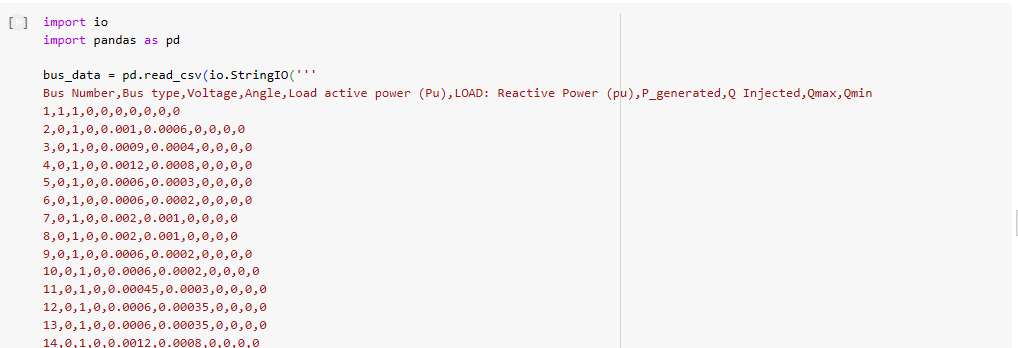

In [ ]:
import io

In [ ]:
import pandas as pd
import io

bus_data = pd.read_csv(io.StringIO('''
Bus Number,Bus Type,Voltage,Angle,Load active power (Pu),LOAD: Reactive power (pu),P_generated,Q_injected,Qmax,Qmin
1,1,1.06,0,0,0,0,0,0,0
2,0,1,0,0.4,-0.1,0,0,0,0
3,2,1.04,0,0,0,3,0.4,1.1,0
4,0,1,0,1.4,0.3,0,0,0,0
5,0,1,0,0.9,0.3,0,0,0,0
6,0,1.04,0,1.6,0.7,0,0,0,0
7,2,1,0,0,0,4,0.6,1.4,0
8,0,1,0,1.3,0.7,0,0,0,0
9,0,1,0,3,0.9,0,0,0,0
10,0,1.02,0,2.1,0.4,0,0,0,0
11,2,1,0,0,0,1.5,0.5,1.14,0
12,0,1,0,0.5,-0.2,0,0,0,0
13,0,1,0,1,-0.3,0,0,0,0
14,0,1,0,1.2,0.6,0,0,0,0
15,0,1,0,5,0.5,0,0,0,0
16,0,1,0,2.5,0.43,0,0,0,0
17,0,1,0,0.7,0.38,0,0,0,0
18,2,1.03,0,0,0,2.8,0.45,1,0
19,0,1,0,2,0.55,0,0,0,0
20,0,1,0,1.5,0.35,0,0,0,0
21,2,1.02,0,0,0,2.4,0.55,1.04,0
22,2,1.05,0,0,0,7,0.68,1.08,0
23,0,1,0,3,0.45,0,0,0,0
24,2,1.04,0,0,0,1.8,0,1.32,0
25,0,1,0,1,0.58,0,0,0,0
26,2,1.01,0,0,0,1.9,-0.35,1.26,0
27,2,1.03,0,0,0,1.5,0.51,1,0
28,2,1.02,0,0,0,1.3,0.8,1.5,0
29,0,1,0,1.2,0.8,0,0,0,0
30,0,1,0,1.3,-0.78,0,0,0,0
31,2,1.03,0,0,0,1.5,0,1,0
32,0,1,0,2,0.67,0,0,0,0
33,2,1.04,0,0,0,2,0.59,1.4,0
34,2,1.02,0,0,0,3,0.65,1.25,0
'''), header=None)





In [ ]:
bus_data

,0,1,2,3,4,5,6,7,8,9
0,Bus Number,Bus Type,Voltage,Angle,Load active power (Pu),LOAD: Reactive power (pu),P_generated,Q_injected,Qmax,Qmin
1,1,1,1.06,0,0,0,0,0,0,0
2,2,0,1,0,0.4,-0.1,0,0,0,0
3,3,2,1.04,0,0,0,3,0.4,1.1,0
4,4,0,1,0,1.4,0.3,0,0,0,0
5,5,0,1,0,0.9,0.3,0,0,0,0
6,6,0,1.04,0,1.6,0.7,0,0,0,0
7,7,2,1,0,0,0,4,0.6,1.4,0
8,8,0,1,0,1.3,0.7,0,0,0,0
9,9,0,1,0,3,0.9,0,0,0,0


## Line data
<a name ="Line_data"></a>

If you arent familiar with python just copy your data from google sheet and paste then edit to with the name line_data. sample is below.

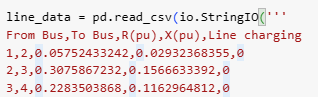

In [ ]:
# import pandas as pd
# import io

# # Line data string with updated "Line charging" values set to 0
# line_data = pd.read_csv(io.StringIO("""
# From Bus,To Bus,R(pu),X(pu),Line charging
# 1,2,0.07807162534,0.6626078972,0
# 1,3,0.02200003673,0.1720001837,0
# 1,31,0.005065197429,0.03895316804,0
# 1,50,0.01074380165,0.091184573,0
# 2,3,0.1000003673,0.7789990817,0
# 2,8,0.01826446281,0.1550137741,0
# 2,9,0.08900012856,0.7630008173,0
# 2,22,0.06999944904,0.5600743802,0
# 2,24,0.04906336088,0.41640955,0
# 2,27,0.018,0.139,0
# 2,28,0.01468319559,0.1246189164,0
# 2,47,0.007162534435,0.06078971534,0
# 3,4,0.00608815427,0.05167125803,0
# 3,5,0.02506887052,0.2127640037,0
# 3,6,0.04906336088,0.41640955,0
# 3,7,0.01074380165,0.091184573,0
# 3,8,0.07162534435,0.6078971534,0
# 3,9,0.08953168044,0.7598714417,0
# 3,50,0.0114600551,0.09726354454,0
# 6,7,0.02148760331,0.182369146,0
# 6,9,0.04099977043,0.3490001837,0
# 9,10,0.02685950413,0.2279614325,0
# 9,12,0.05599955005,0.4770003122,0
# 10,12,0.02865013774,0.2431588613,0
# 11,12,0.08738292011,0.7416345271,0
# 11,17,0.03400022039,0.2920004408,0
# 11,21,0.05209917355,0.400661157,0
# 11,49,0.04124517906,0.3171900826,0
# 12,13,0.003000036731,0.022,0
# 12,15,0.02900008264,0.02459997521,0
# 14,15,0.01109082645,0.09419986226,0
# 16,17,0.08236914601,0.6990817264,0
# 17,18,0.06964389348,0.5959587879,0
# 18,19,0.09464242424,0.8069430303,0
# 18,36,0.08321395776,0.6399449036,0
# 19,20,0.08595041322,0.729476584,0
# 19,33,0.04834710744,0.4103305785,0
# 20,35,0.04727272727,0.4012121212,0
# 21,49,0.01085399449,0.08347107438,0
# 22,23,0.0003617998163,0.002782369146,0
# 22,47,0.06983471074,0.5926997245,0
# 22,48,0.01374839302,0.1057300275,0
# 24,25,0.04899950413,0.4190004408,0
# 24,26,0.03400022039,0.2920004408,0
# 24,29,0.02170798898,0.1669421488,0
# 24,37,0.04956657484,0.381184573,0
# 25,30,0.009044995409,0.06955922865,0
# 25,37,0.02170798898,0.1669421488,0
# 25,39,0.01374839302,0.1057300275,0
# 26,38,0.001808999082,0.01391184573,0
# 27,32,0.02299991736,0.1900002479,0
# 28,32,0.0114600551,0.09726354454,0
# 30,39,0.03256198347,0.2504132231,0
# 30,40,0.01628099174,0.1252066116,0
# 31,51,0.009406795225,0.0723415978,0
# 33,34,0.05013774105,0.4255280073,0
# 36,45,0.01808999082,0.1391184573,0
# 37,44,0.01085399449,0.08347107438,0
# 38,39,0.05173737374,0.3978787879,0
# 38,45,0.05426997245,0.4173553719,0
# 39,41,0.02604958678,0.2003305785,0
# 39,42,0.02713498623,0.208677686,0
# 43,44,0.01085399449,0.08347107438,0
# 46,47,0.001808999082,0.01391184573,0
# 48,49,0.05065197429,0.3895316804,0
# """), header=None )

In [ ]:
import pandas as pd
import io

line_data = pd.read_csv(io.StringIO("""
From Bus,To Bus,R (pu),X (pu),Line Charging
1,2,0.0121836,0.0916336,1.21
1,4,0.0015918,0.0119716,0.31
3,4,0.0001572,0.0094178,0
4,5,0.0047827,0.0360219,0.09
4,9,0.0020565,0.0154692,0.07
5,6,0.0018864,0.0141884,0.36
5,7,0.0003144,0.0188355,0
5,10,0.0018864,0.0141884,0.37
8,9,0.0053843,0.0404961,0.33
8,15,0.0053343,0.0405651,0.45
9,15,0.0065432,0.0426547,0.55
9,16,0.0098648,0.0741936,0.98
10,13,0.0090394,0.0679862,0.52
10,14,0.0077425,0.0582316,0.77
11,15,0.0020643,0.0103951,0.31
12,15,0.0040534,0.0305103,0.41
14,17,0.010415,0.0783319,0.01
15,16,0.0110045,0.0827653,0.09
15,20,0.0003527,0.0026574,0.05
15,21,0.0055023,0.0413829,0.35
15,22,0.0012184,0.0091634,0.2
16,18,0.0063843,0.0404961,0.15
16,19,0.0038336,0.0288242,0.76
16,21,0.0055023,0.0413829,0.55
16,23,0.0053843,0.0404961,0.38
16,24,0.0009826,0.0073898,0.19
18,25,0.0010218,0.0076553,0.1
19,26,0.0005109,0.0038427,0.38
19,27,0.0006105,0.0038427,0.4
22,28,0.0005109,0.0036458,0.3
22,29,0.0002749,0.0020654,0.2
23,30,0.003773,0.0283768,0.37
23,31,0.004913,0.0036949,0.09
23,32,0.00605225,0.0455212,0.02
24,25,0.002476,0.0186223,0.24
28,29,0.003464,0.0206114,0.3
32,33,0.0009825,0.0073898,0.09
33,34,0.0005109,0.0038427,0.3
"""), header=None)

In [ ]:

line_data

,0,1,2,3,4
0,From Bus,To Bus,R (pu),X (pu),Line Charging
1,1,2,0.0121836,0.0916336,1.21
2,1,4,0.0015918,0.0119716,0.31
3,3,4,0.0001572,0.0094178,0
4,4,5,0.0047827,0.0360219,0.09
5,4,9,0.0020565,0.0154692,0.07
6,5,6,0.0018864,0.0141884,0.36
7,5,7,0.0003144,0.0188355,0
8,5,10,0.0018864,0.0141884,0.37
9,8,9,0.0053843,0.0404961,0.33


## Setup
<a name = "setup"></a>

In [ ]:

line_data = line_data.to_numpy()

In [ ]:
# prompt: convert pd to  numpy without the header, remove the header and convert to float

bus_data_values = bus_data.values[1:, :].astype(np.float64) # remove the header and convert to float
line_data_values = line_data[1:, :].astype(np.float64) # remove the header and convert to float


## Initial  State

In [ ]:
bus_data_values.sum(axis = 0)

array([595.  ,  27.  ,  34.45,   0.  ,  33.6 ,   7.23,  33.7 ,   5.38,
        15.49,   0.  ])

In [ ]:

V, Y_bus,R_bus, bus_data, Pd_pu, Qd_pu, Pg_pu, Qg_pu, Q_max, Q_min = setup_power_system(bus_data_values, line_data_values)

In [ ]:
pd.DataFrame(Y_bus)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,12.339516-91.283338j,-1.425790+10.723455j,0.000000+ 0.000000j,-10.913726+ 82.079883j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
1,-1.425790+10.723455j,1.425790- 9.513455j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
2,0.000000+ 0.000000j,0.000000+ 0.000000j,1.771873-106.152335j,-1.771873+106.152335j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
3,-10.913726+82.079883j,0.000000+ 0.000000j,-1.771873+106.152335j,24.752324-278.564137j,-3.622019+ 27.279987j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-8.444706+ 63.521931j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
4,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-3.622019+ 27.279987j,22.923617-218.048229j,-9.207826+69.255896j,-0.885946+53.076449j,0.000000+ 0.000000j,0.000000+ 0.000000j,-9.207826+69.255896j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
5,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-9.207826+ 69.255896j,9.207826-68.895896j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
6,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-0.885946+ 53.076449j,0.000000+ 0.000000j,0.885946-53.076449j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
7,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,6.412802-47.717481j,-3.226209+ 24.264784j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
8,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-8.444706+ 63.521931j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-3.226209+24.264784j,16.945480-122.005920j,0.000000+ 0.000000j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j
9,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,-9.207826+ 69.255896j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000000+ 0.000000j,13.373175-98.923745j,...,0.000000+ 0.000000j,0.000000+ 0.000000j,0.000

In [ ]:
result,C = newton_raphson_load_flow(Y_bus, V, bus_data, Pd_pu, Qd_pu, Pg_pu, Qg_pu, Q_max, Q_min)

The jacobian matrix 
            0           1           2           3          4          5   \
0   11.366862   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
1   -0.000000  110.398429 -110.398429   -0.000000  -0.000000  -0.000000   
2   -0.000000 -110.398429  288.205023  -27.279987  -0.000000  -0.000000   
3   -0.000000   -0.000000  -27.279987  223.023582 -72.026132 -53.076449   
4   -0.000000   -0.000000   -0.000000  -72.026132  72.026132  -0.000000   
5   -0.000000   -0.000000   -0.000000  -53.076449  -0.000000  53.076449   
6   -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
7   -0.000000   -0.000000  -63.521931   -0.000000  -0.000000  -0.000000   
8   -0.000000   -0.000000   -0.000000  -70.641014  -0.000000  -0.000000   
9   -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
10  -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
11  -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
12 

In [ ]:
fr = pd.DataFrame(result, columns = ['Bus number', 'bus type', 'voltage magnitude', 'voltage angle', 'Pd', 'Qd', 'Pg', 'Qg', 'Qmax', 'Qmin'])

In [ ]:
fr

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
0,1.0,1.0,1.060000,0.000000,0.0,0.00,0.535352,-2.039134,0.00,0.0
1,2.0,0.0,1.194933,-0.046535,0.4,-0.10,0.000000,0.000000,0.00,0.0
2,3.0,2.0,1.040000,0.026764,0.0,0.00,3.000000,-0.615768,1.10,0.0
3,4.0,0.0,1.045478,0.000687,1.4,0.30,0.000000,0.000000,0.00,0.0
4,5.0,0.0,1.023117,-0.121490,0.9,0.30,0.000000,0.000000,0.00,0.0
5,6.0,0.0,1.015318,-0.142748,1.6,0.70,0.000000,0.000000,0.00,0.0
6,7.0,2.0,1.000000,-0.047430,0.0,0.00,4.000000,-1.145208,1.40,0.0
7,8.0,0.0,1.035854,0.051239,1.3,0.70,0.000000,0.000000,0.00,0.0
8,9.0,0.0,1.044041,0.029312,3.0,0.90,0.000000,0.000000,0.00,0.0
9,10.0,0.0,1.034947,-0.192280,2.1,0.40,0.000000,0.000000,0.00,0.0


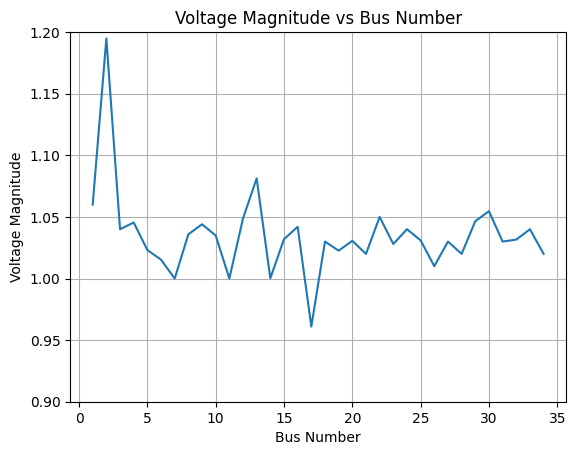

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'fr' is your DataFrame containing the results
plt.plot(fr['Bus number'], fr['voltage magnitude'])
plt.xlabel('Bus Number')
plt.ylabel('Voltage Magnitude')
plt.ylim([0.90,1.2])
plt.title('Voltage Magnitude vs Bus Number')
plt.grid(True)
plt.show()


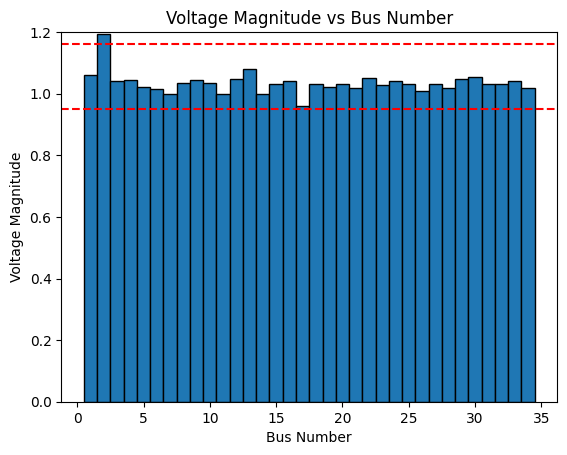

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'fr' is your DataFrame containing the results
plt.bar(fr['Bus number'], fr['voltage magnitude'], width=1.0, edgecolor='black')
plt.xlabel('Bus Number')
plt.ylabel('Voltage Magnitude')
plt.ylim([0.0, 1.2])
plt.title('Voltage Magnitude vs Bus Number')
plt.grid(False)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axhline(y=1.16, color='r', linestyle='--')
plt.show()


In [ ]:
fr[fr['voltage magnitude'] == fr['voltage magnitude'].min()]

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
16,17.0,0.0,0.961016,-0.350983,0.7,0.38,0.0,0.0,0.0,0.0


In [ ]:
fr[fr['voltage magnitude'] == fr['voltage magnitude'].max()]

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
1,2.0,0.0,1.194933,-0.046535,0.4,-0.1,0.0,0.0,0.0,0.0


In [ ]:
(fr['Pg'] - fr['Pd']).sum()

0.6353522920384815

# Run the coot Algorithm
<a name ="COOT_Parameters"></a>

In [ ]:
# Parameters
num_dgs = 2  # Number of DG units
N = 19
Max_iter = 50
lb = [2, 0]  * num_dgs  # Lower bounds for positions and values
lb = np.array(lb)
ub = [20, 0.5] * num_dgs  # Upper bounds for positions and values
ub = np.array(ub)
dim = 2 * num_dgs  # Dimensionality for multiple DGs

# Run COOT algorithm for multiple DGs
Convergence_curve, gBest, gBestScore = COOT(N, Max_iter, lb, ub, dim, fitness_function)
print("Best Score:", gBestScore)
print("Best Positions and Values:", gBest)


Streaming output truncated to the last 5000 lines.
19   0.000000    0.000000    0.000000   0.000000  ...   -1.979801   -2.041905   
20   0.000000    0.000000    0.000000   0.000000  ...   -8.385305    0.000000   
21   0.000000    0.000000    0.000000  -0.000000  ...    0.000000   -3.200131   
22   0.000000    0.000000    0.000000  -0.000000  ...    0.000000  -17.445045   
23   0.000000    0.000000    0.000000  -0.000000  ...    0.000000    0.000000   
24   0.000000    0.000000    0.000000   0.000000  ...    0.000000    0.000000   
25   0.000000    0.000000    0.000000   0.000000  ...    0.000000    0.000000   
26   0.000000    0.000000    0.000000   0.000000  ...    0.000000    0.000000   
27   0.000000    0.000000    0.000000   0.000000  ...    0.000000    0.000000   
28   0.000000    0.000000    0.000000  -0.000000  ...    0.000000    0.000000   
29   0.000000    0.000000    0.000000  -0.000000  ...    0.000000    0.000000   
30   0.000000    0.000000    0.000000   0.000000  ...    0

In [ ]:
updates =  break_down(gBest)
updates

[(14.0, 0.0)]

## Evaluate result
<a name ="Evaluate_result"></a>

In [ ]:
power_loss, pl, fr = evaluate_dg_placement(bus_data_values, line_data_values , [], bus_type = 2 )

The jacobian matrix 
            0           1           2           3          4          5   \
0   11.366862   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
1   -0.000000  110.398429 -110.398429   -0.000000  -0.000000  -0.000000   
2   -0.000000 -110.398429  288.205023  -27.279987  -0.000000  -0.000000   
3   -0.000000   -0.000000  -27.279987  223.023582 -72.026132 -53.076449   
4   -0.000000   -0.000000   -0.000000  -72.026132  72.026132  -0.000000   
5   -0.000000   -0.000000   -0.000000  -53.076449  -0.000000  53.076449   
6   -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
7   -0.000000   -0.000000  -63.521931   -0.000000  -0.000000  -0.000000   
8   -0.000000   -0.000000   -0.000000  -70.641014  -0.000000  -0.000000   
9   -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
10  -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
11  -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
12 

In [ ]:
plos = fr['Pg'] - fr['Pd']
plos.sum(axis = 0)

0.6353522920384815

In [ ]:
# power_loss_op, pl_op, fr_op = evaluate_dg_placement(bus_data_values, line_data_values , [(14, 0.5)], bus_type = 2 )
power_loss_op, pl_op, fr_op = evaluate_dg_placement(bus_data_values, line_data_values , updates, bus_type = 0 )


21 14.0
The jacobian matrix 
            0           1           2           3          4          5   \
0   11.366862   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
1   -0.000000  110.398429 -110.398429   -0.000000  -0.000000  -0.000000   
2   -0.000000 -110.398429  288.205023  -27.279987  -0.000000  -0.000000   
3   -0.000000   -0.000000  -27.279987  223.023582 -72.026132 -53.076449   
4   -0.000000   -0.000000   -0.000000  -72.026132  72.026132  -0.000000   
5   -0.000000   -0.000000   -0.000000  -53.076449  -0.000000  53.076449   
6   -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
7   -0.000000   -0.000000  -63.521931   -0.000000  -0.000000  -0.000000   
8   -0.000000   -0.000000   -0.000000  -70.641014  -0.000000  -0.000000   
9   -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
10  -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.000000   
11  -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  -0.00000

In [ ]:
fr_op

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
0,1.0,1.0,1.060000,0.000000,0.0,0.00,3.245798,-2.432102,0.00,0.0
1,2.0,0.0,1.194933,-0.046535,0.4,-0.10,0.000000,0.000000,0.00,0.0
2,3.0,2.0,1.040000,-0.003069,0.0,0.00,3.000000,-0.705407,1.10,0.0
3,4.0,0.0,1.046290,-0.029139,1.4,0.30,0.000000,0.000000,0.00,0.0
4,5.0,0.0,1.023443,-0.151115,0.9,0.30,0.000000,0.000000,0.00,0.0
5,6.0,0.0,1.015649,-0.172359,1.6,0.70,0.000000,0.000000,0.00,0.0
6,7.0,2.0,1.000000,-0.077074,0.0,0.00,4.000000,-1.162517,1.40,0.0
7,8.0,0.0,1.039065,-0.036237,1.3,0.70,0.000000,0.000000,0.00,0.0
8,9.0,0.0,1.047641,-0.039823,3.0,0.90,0.000000,0.000000,0.00,0.0
9,10.0,0.0,1.035305,-0.221862,2.1,0.40,0.000000,0.000000,0.00,0.0


In [ ]:
pl_op

(0.5457982952432499, -22.547285498695455)

In [ ]:
pl

(0.6353522920384815, -21.839608970188596)

In [ ]:
((pl[0] - pl_op[0])/pl[0]) *100

19.06036031792658

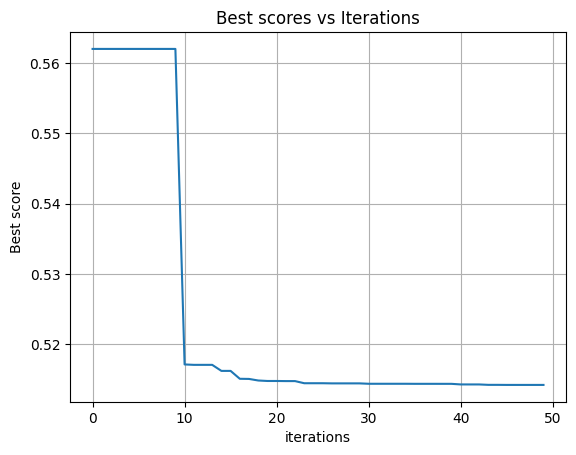

In [ ]:

import matplotlib.pyplot as plt
# Assuming 'fr' is your DataFrame containing the results
plt.plot(range(len(Convergence_curve)), Convergence_curve)
plt.xlabel('iterations')
plt.ylabel('Best score')
plt.title('Best scores vs Iterations')
plt.grid(True)
plt.show()


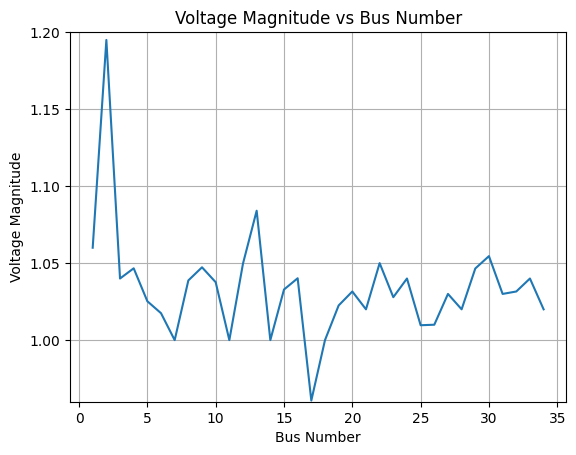

In [ ]:
# prompt: plot voltage vs bus number

import matplotlib.pyplot as plt
# Assuming 'fr' is your DataFrame containing the results
plt.plot(fr_op['Bus number'], fr_op['voltage magnitude'])
plt.xlabel('Bus Number')
plt.ylabel('Voltage Magnitude')
plt.ylim([0.96,1.2])
plt.title('Voltage Magnitude vs Bus Number')
plt.grid(True)
plt.show()


In [ ]:
# fr_op
fr_op[fr_op['voltage magnitude'] == fr_op['voltage magnitude'].min()]

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
16,17.0,0.0,0.960775,-0.319648,0.7,0.38,0.0,0.0,0.0,0.0


In [ ]:
fr_op[fr_op['voltage magnitude'] == fr_op['voltage magnitude'].max()]

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
1,2.0,0.0,1.194933,-0.046535,0.4,-0.1,0.0,0.0,0.0,0.0


In [ ]:
fr_op

,Bus number,bus type,voltage magnitude,voltage angle,Pd,Qd,Pg,Qg,Qmax,Qmin
0,1.0,1.0,1.060000,0.000000,0.0,0.00,2.714254,-2.406521,0.00,0.0
1,2.0,0.0,1.194933,-0.046535,0.4,-0.10,0.000000,0.000000,0.00,0.0
2,3.0,2.0,1.040000,0.002712,0.0,0.00,3.000000,-0.744117,1.10,0.0
3,4.0,0.0,1.046641,-0.023355,1.4,0.30,0.000000,0.000000,0.00,0.0
4,5.0,0.0,1.025240,-0.127065,0.9,0.30,0.000000,0.000000,0.00,0.0
5,6.0,0.0,1.017479,-0.148237,1.6,0.70,0.000000,0.000000,0.00,0.0
6,7.0,2.0,1.000000,-0.053125,0.0,0.00,4.000000,-1.258050,1.40,0.0
7,8.0,0.0,1.038768,-0.030537,1.3,0.70,0.000000,0.000000,0.00,0.0
8,9.0,0.0,1.047287,-0.034085,3.0,0.90,0.000000,0.000000,0.00,0.0
9,10.0,0.0,1.037621,-0.190573,2.1,0.40,0.000000,0.000000,0.00,0.0


In [ ]:
# import matplotlib.pyplot as plt

# # Assuming 'fr' is your DataFrame containing the results
# plt.bar(fr_op['Bus number'], fr_op['voltage magnitude'], width=1.0, edgecolor='black')
# plt.xlabel('Bus Number')
# plt.ylabel('Voltage Magnitude')
# plt.ylim([0.0, 1.2])
# plt.title('Voltage Magnitude vs Bus Number')
# plt.grid(False)
# plt.axhline(y=0.95, color='r', linestyle='--')
# plt.axhline(y=1.08, color='r', linestyle='--')
# plt.show()

In [ ]:
updates

[(11.0, 0.4999977363155572), (14.0, 0.0)]